In [301]:
import pandas as pd
from scipy.stats import zscore
from haversine import haversine
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
import numpy as np
import matplotlib.pyplot as plt

In [302]:
data = pd.read_excel('data/newph.xlsx')

In [303]:
data.columns

Index(['price', 'lnprice', 'pricemeter', 'lnpricemeter', 'district', 'DZ',
       'IN', 'MO', 'SV', 'OR', 'KI', 'LE', 'rooms', 'housefloor', 'firstfloor',
       'totalfloor', 'livesq', 'kitsq', 'totalsq', 'house_type', 'PG', 'HR',
       'BR', 'IP', 'SP', 'UP', 'LP', 'MG', 'MS', 'ST', 'brick', 'panel',
       'realtor', 'dist_super', 'dist_hyper', 'longitude', 'latitude', '500_m',
       '1000_m', '238_m'],
      dtype='object')

In [304]:
data.describe()

,price,lnprice,pricemeter,lnpricemeter,DZ,IN,MO,SV,OR,KI,...,brick,panel,realtor,dist_super,dist_hyper,longitude,latitude,500_m,1000_m,238_m
count,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,...,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000,14613.000000
mean,2965.014858,7.888035,56.722408,4.016386,0.164237,0.155683,0.159515,0.185520,0.122973,0.161568,...,0.522617,0.477383,0.875111,0.194911,6.623320,56.202230,58.015188,4.383015,12.675494,1.277630
std,1729.913123,0.434118,11.751800,0.212090,0.370503,0.362567,0.366169,0.388732,0.328417,0.368067,...,0.499505,0.499505,0.330604,0.145001,4.845025,0.130129,0.043282,3.619809,7.572576,1.647042
min,295.000000,5.686975,7.879433,2.064256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.001413,0.023542,55.827973,57.944565,0.000000,0.000000,0.000000
25%,2050.000000,7.625595,48.983051,3.891474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.105629,2.045820,56.152927,57.987595,2.000000,7.000000,0.000000
50%,2550.000000,7.843849,55.555556,4.017384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.166479,4.824859,56.225009,58.004865,4.000000,11.000000,1.000000
75%,3300.000000,8.101678,63.829787,4.156220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.250092,11.626932,56.290112,58.028654,5.000000,16.000000,2.000000
max,27800.000000,10.232791,112.121212,4.719581,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.599272,18.730365,56.612610,58.166159,28.000000,41.000000,21.000000


## Cleaning, remove outliers, add feature

In [305]:
def reject_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """Function removes outliers
    :param df: Original DataFrame
    :return: Updated DataFrame
    """
    for column in ['pricemeter', 'price', 'totalsq']:
        df = df[zscore(df[column].values) < 3]
    return df
    
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Function removes excess columns
    :param df: Original DataFrame
    :return: Updated DataFrame
    """
    excess_columns = ['pricemeter','district','DZ','IN', 'MO', 'SV', 'OR', 'KI', 'LE', 'lnprice', 'lnpricemeter','house_type', '500_m', '1000_m', '238_m']
    df.drop(excess_columns, inplace = True, axis = 1)
    return df 

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """Function adds feature
    :param df: Original DataFrame
    :return: Updated DataFrame
    """
    center_point = [58.011293, 56.237305] #координата местного ЦУМа
    df['distance from center'] = list(map(lambda point: haversine(center_point, point), df[['latitude', 'longitude']].values))
    df.drop(['latitude', 'longitude'], inplace = True, axis = 1)
    return df

In [306]:
data = add_features(clean_data(reject_outliers(data)))

In [307]:
data.describe()

,price,rooms,housefloor,firstfloor,totalfloor,livesq,kitsq,totalsq,PG,HR,...,LP,MG,MS,ST,brick,panel,realtor,dist_super,dist_hyper,distance from center
count,14029.000000,14029.000000,14029.000000,14029.000000,11643.000000,8727.000000,9051.000000,14029.000000,14029.000000,14029.000000,...,14029.000000,14029.000000,14029.000000,14029.000000,14029.000000,14029.000000,14029.000000,14029.000000,14029.000000,14029.000000
mean,2726.518064,1.965999,4.533752,0.189679,8.657391,30.196095,8.166966,49.350349,0.066648,0.198446,...,0.024378,0.001354,0.045263,0.007057,0.514506,0.485494,0.874546,0.194332,6.645645,7.616937
std,1048.231242,0.880466,3.718603,0.392061,4.889786,30.395242,3.185652,17.566522,0.249420,0.398844,...,0.154225,0.036778,0.207889,0.083711,0.499807,0.499807,0.331245,0.143801,4.850455,5.492686
min,295.000000,1.000000,1.000000,0.000000,2.000000,3.000000,1.000000,12.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001413,0.023542,0.035653
25%,2050.000000,1.000000,2.000000,0.000000,5.000000,18.000000,6.000000,36.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.105629,2.034368,3.479311
50%,2500.000000,2.000000,4.000000,0.000000,9.000000,29.000000,8.000000,45.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.165927,4.843783,5.553106
75%,3200.000000,3.000000,6.000000,0.000000,10.000000,38.500000,9.000000,60.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.249389,11.629358,12.123119
max,7600.000000,9.000000,25.000000,1.000000,26.000000,2600.000000,100.000000,107.500000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.599272,18.730365,24.172379


## Catboost model

In [308]:
X = data.iloc[:,1:]
y = data.iloc[:,0]

In [309]:
X.shape, y.shape

((14029, 23), (14029,))

In [310]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [311]:
scores = []
for train_index, test_index in kf.split(X, y):

    x_train, x_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_cb = CatBoostRegressor(eval_metric='RMSE')
    model_cb.fit(x_train, y_train, eval_set=[(x_test, y_test)],
                 early_stopping_rounds=20, use_best_model=True,
                 verbose=0)

    scores.append(model_cb.best_score_['validation']['RMSE'])
    model_cb.save_model(f'catboost{len(scores)}.cbm')

print('Average RMSE:', np.mean(scores))
for i, score in enumerate(scores):
    print(f'Model {i+1} RMSE: {score}')

Average RMSE: 327.59729831073844
Model 1 RMSE: 332.22376604165504
Model 2 RMSE: 309.1211726206091
Model 3 RMSE: 366.45741325459
Model 4 RMSE: 313.63910770524427
Model 5 RMSE: 316.545031931594


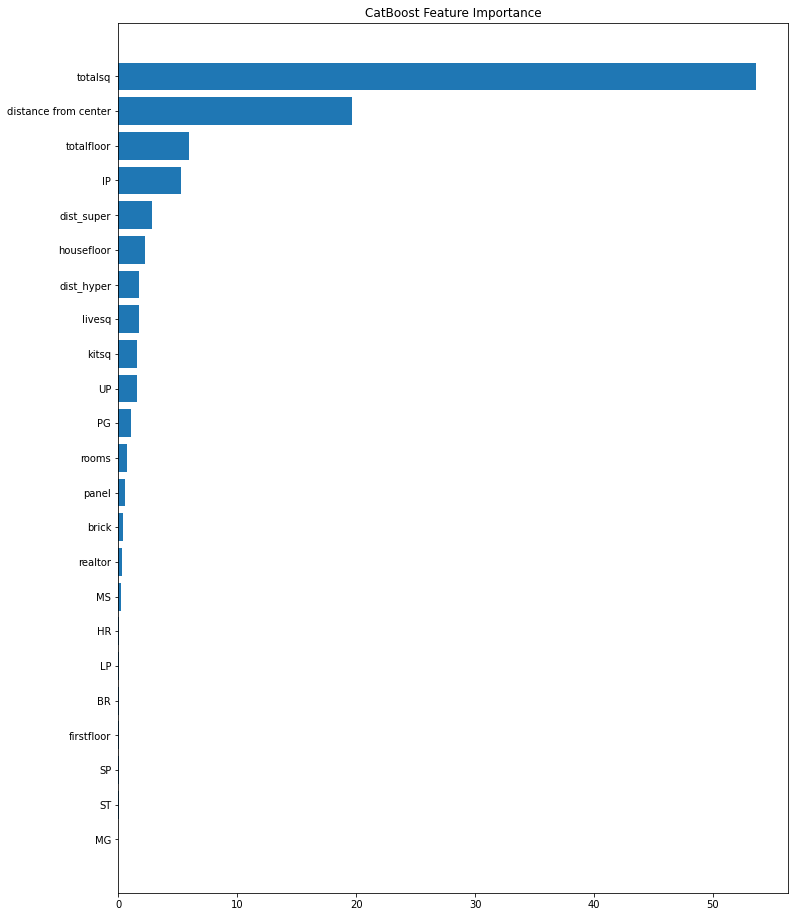

In [312]:
importance = pd.DataFrame({
    'features': X.columns,
    'importance': model_cb.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('CatBoost Feature Importance')
plt.show()